In [1]:
import jupyter_utils as j

j.reload(j)

In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split as split
from sklearn import metrics

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score

from matplotlib import pyplot as plt

import matplotlib

matplotlib.style.use('ggplot')

j.apply_options(pd)
j.reload(j)

%matplotlib inline

In [3]:
data = pd.read_csv('sparkify_data_final.csv')
data = data.drop(['userId'] ,axis = 1)

In [4]:
data.head(5)

,male,paid,canceled,avg_session_duration,n_actions,n_added_to_playlist,n_ads,n_dislikes,n_downgrades,n_errors,n_friends,n_help,n_home,n_likes,n_sess,n_settings,n_songs,n_upgrades,session_avg_actions,session_avg_added_playlist,session_avg_ads,session_avg_dislikes,session_avg_errors,session_avg_friends,session_avg_help,session_avg_home,session_avg_likes,session_avg_playback,session_avg_settings,session_avg_songs,session_avg_time_away,time_window
0,1,1,0,8.064826,682,20,3,10,1,3,12,5,27,25,9,4,557,0,17.669538,0.518168,0.077725,0.259084,0.077725,0.310901,0.129542,0.699527,0.647710,1.016793,0.103634,14.430986,152.105347,1255.440278
1,0,1,1,4.353918,349,12,2,2,0,1,7,1,14,10,7,1,287,1,17.434019,0.599451,0.099908,0.099908,0.049954,0.349679,0.049954,0.699359,0.499542,1.020685,0.049954,14.336858,65.024815,410.167222
2,1,0,0,1.315119,28,0,0,0,0,0,1,0,3,0,2,1,22,0,18.241042,0.000000,0.000000,0.000000,0.000000,0.651466,0.000000,1.954397,0.000000,2.109316,0.651466,14.332248,298.926389,300.461389
3,1,0,0,2.790073,531,9,30,6,0,0,9,1,26,21,15,1,408,0,19.514685,0.330757,1.102525,0.220505,0.000000,0.330757,0.036751,0.955521,0.771767,1.040109,0.036751,14.994334,90.768254,1297.965833
4,0,0,0,2.471243,228,11,21,3,0,3,2,2,5,12,7,2,159,0,21.472296,1.035944,1.977712,0.282530,0.282530,0.188353,0.188353,0.470884,1.130121,1.039006,0.188353,14.974101,145.537407,883.842778


In [5]:
data.canceled.value_counts()

0    17275
1     5003
Name: canceled, dtype: int64

In [6]:
data.male.value_counts()

1    11651
0    10627
Name: male, dtype: int64

In [7]:
data.paid.value_counts()

1    11275
0    11003
Name: paid, dtype: int64

In [35]:
def plot_roc_curve(y_test, y_predictions, model):
    
    fp, tp, _ = roc_curve(y_test, y_predictions)
    auc = roc_auc_score(y_test, y_predictions)
    
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp, tp, color = 'darkorange', label = model.__class__.__name__)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve (area = {np.around(auc, 4)})')
    plt.legend(loc = 'best')
    plt.show()
    
def plot_metrics(y_test, y_predictions):
    
    auc = roc_auc_score(y_test, y_predictions)
    cm = confusion_matrix(y_test, y_predictions, labels = [1, 0])
    
    tn = cm[0, 0]
    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    
    total = np.sum(cm) # tn + tp + fn + fp
    accuracy = (tp + tn) / total
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn) 
    
    print(cm)
    print('')
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('auc......................%7.4f' % auc)
    print('F1 macro.................%7.4f' % f1_score(y_test, y_predictions, average = 'macro'))
    print('F1 micro.................%7.4f' % f1_score(y_test, y_predictions, average = 'micro'))
    print('F1 weighted..............%7.4f' % f1_score(y_test, y_predictions, average = 'weighted'))
    # f1 = (2 * tp ) / (2 * tp + fp + fn) - f1_score with average 'binary'
    print('F1 binary................%7.4f' % f1_score(y_test, y_predictions, average = 'binary'))
    
def train_model(df, label, classifier): 

    x = df.drop([label], axis = 1)
    y = df[label]

    X_train, X_test, y_train, y_test = split(x, y, test_size = .3, random_state = 42)
    
    model = classifier.fit(X_train, y_train)
    
    y_predicted = model.predict(X_test)
    plot_roc_curve(y_test, y_predicted, model)
    plot_metrics(y_test, y_predicted)
    
    #y_predicted = model.predict(X_test)
    #plot_roc_curve(y_test, y_predicted, model)
    #plot_metrics(y_test, y_predicted)
    
    return model

def train_random_forest(df, label):
    
    cl = RandomForestClassifier(n_estimators = 100, n_jobs = -1, class_weight = 'balanced', criterion = 'gini', random_state = 42)
    return train_model(df, label, cl)

def train_logistic_regression(df, label):
    
    lr = LogisticRegression(solver = 'lbfgs', n_jobs = -1, class_weight = 'balanced', random_state = 42)
    return train_model(df, label, lr)

def train_gradient_boosting(df, label): 
    gbl = GradientBoostingClassifier(n_estimators = 300, max_depth = 8, learning_rate = 0.1, random_state = 42)
    return train_model(df, label, gbl)


In [11]:
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler

# Filter average or absolute columns
features_to_normalize = list(filter(lambda column_name: '_' in column_name, data.columns))

_x = data.copy()
_x[features_to_normalize] = StandardScaler().fit_transform(_x[features_to_normalize])
_x = _x.drop(list(filter(lambda column_name: 'n_pppppp' in column_name, _x.columns)), axis = 1)

_x.head(5)

,male,paid,canceled,avg_session_duration,n_actions,n_added_to_playlist,n_ads,n_dislikes,n_downgrades,n_errors,n_friends,n_help,n_home,n_likes,n_sess,n_settings,n_songs,n_upgrades,session_avg_actions,session_avg_added_playlist,session_avg_ads,session_avg_dislikes,session_avg_errors,session_avg_friends,session_avg_help,session_avg_home,session_avg_likes,session_avg_playback,session_avg_settings,session_avg_songs,session_avg_time_away,time_window
0,1,1,0,-0.111854,-0.092447,-0.213251,-0.692452,-0.058466,1.169450,0.289468,-0.250159,-0.011409,-0.012119,-0.413180,-0.010792,-0.330697,-0.344592,-0.898424,-0.021950,0.563857,-0.251358,0.279902,1.030065,0.014746,0.247101,-0.014799,-0.318415,-0.018363,-0.022954,-0.014382,0.098440,0.600827
1,0,1,1,-0.723315,-0.154426,-0.462701,-0.740905,-0.692599,-0.481146,-0.026091,-0.493889,-0.034669,-0.016852,-0.645423,-0.012680,-0.712012,-0.590135,0.424013,-0.023878,0.970758,-0.241180,-0.347516,0.544720,0.039887,-0.288743,-0.014804,-0.665224,-0.017089,-0.098365,-0.016321,-0.495053,-1.264182
2,1,0,0,-1.224029,-0.214171,-0.836876,-0.837812,-0.851132,-0.481146,-0.183871,-0.786366,-0.040484,-0.020856,-0.800252,-0.017400,-0.712012,-0.831132,-0.898424,-0.017271,-2.030104,-0.287020,-0.741322,-0.328314,0.235541,-0.625071,0.021271,-1.834473,0.339537,0.746666,-0.016416,1.099090,-1.506237
3,1,0,0,-0.980995,-0.120552,-0.556245,0.615785,-0.375532,-0.481146,-0.183871,-0.396397,-0.034669,-0.012483,-0.475111,-0.005128,-0.712012,-0.480095,-0.898424,-0.006843,-0.374325,0.218843,0.127836,-0.328314,0.027619,-0.377638,-0.007441,-0.028042,-0.010725,-0.116914,-0.002772,-0.319600,0.694656
4,0,0,0,-1.033530,-0.176947,-0.493882,0.179706,-0.613332,-0.481146,0.289468,-0.737620,-0.028854,-0.020128,-0.614457,-0.012680,-0.584907,-0.706541,-0.898424,0.009183,3.155854,0.620399,0.372319,4.609378,-0.064704,0.643062,-0.021372,0.810736,-0.011087,0.096065,-0.003189,0.053676,-0.219065


In [ ]:
_x[_x.columns[4:]].apply(lambda x: x/_x.time_window, axis = 1)

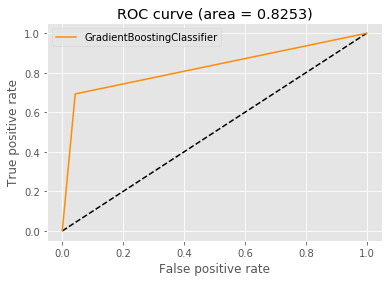

[[1052  466]
 [ 219 4947]]

accuracy................. 0.8975
precision................ 0.9139
recall................... 0.9576
auc...................... 0.8253
F1 macro................. 0.8448
F1 micro................. 0.8975
F1 weighted.............. 0.8942
F1 binary................ 0.7544


In [36]:
model = train_gradient_boosting(_x, 'canceled')

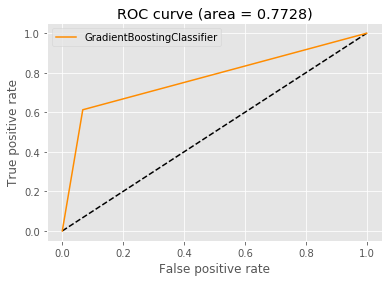

[[19 12]
 [ 7 97]]

accuracy................. 0.8593
precision................ 0.8899
recall................... 0.9327
auc...................... 0.7728
F1 macro................. 0.7887
F1 micro................. 0.8593
F1 weighted.............. 0.8547
F1 binary................ 0.6667


In [43]:
model = train_gradient_boosting(_x, 'canceled')

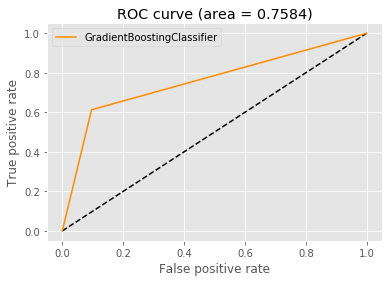

[[19 12]
 [10 94]]

accuracy................. 0.8370
precision................ 0.8868
recall................... 0.9038
auc...................... 0.7584
F1 macro................. 0.7643
F1 micro................. 0.8370
F1 weighted.............. 0.8351
F1 binary................ 0.6333


In [13]:
model = train_gradient_boosting(_x, 'canceled')

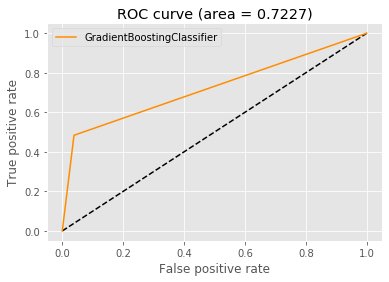

[[ 15  16]
 [  4 100]]

accuracy................. 0.8519
precision................ 0.8621
recall................... 0.9615
auc...................... 0.7227
F1 macro................. 0.7545
F1 micro................. 0.8519
F1 weighted.............. 0.8381
F1 binary................ 0.6000


In [107]:
model = train_gradient_boosting(_x, 'canc')

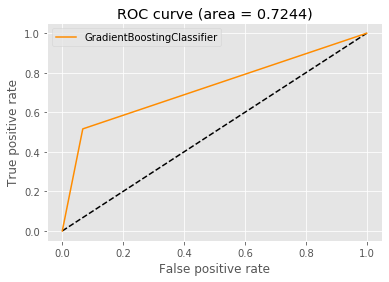

[[16 15]
 [ 7 97]]

accuracy................. 0.8370
precision................ 0.8661
recall................... 0.9327
auc...................... 0.7244
F1 macro................. 0.7454
F1 micro................. 0.8370
F1 weighted.............. 0.8280
F1 binary................ 0.5926


In [101]:
model = train_gradient_boosting(_x, 'canc')

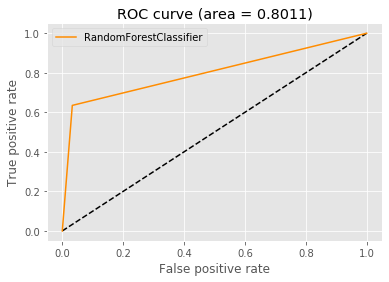

[[ 964  554]
 [ 170 4996]]

accuracy................. 0.8917
precision................ 0.9002
recall................... 0.9671
auc...................... 0.8011
F1 macro................. 0.8297
F1 micro................. 0.8917
F1 weighted.............. 0.8858
F1 binary................ 0.7270


In [13]:
model = train_random_forest(_x, 'canceled')

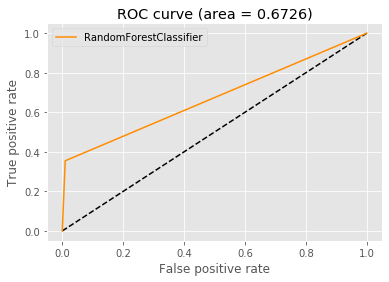

[[ 11  20]
 [  1 103]]

accuracy................. 0.8444
precision................ 0.8374
recall................... 0.9904
auc...................... 0.6726
F1 macro................. 0.7096
F1 micro................. 0.8444
F1 weighted.............. 0.8166
F1 binary................ 0.5116


In [44]:
model = train_random_forest(_x, 'canceled')

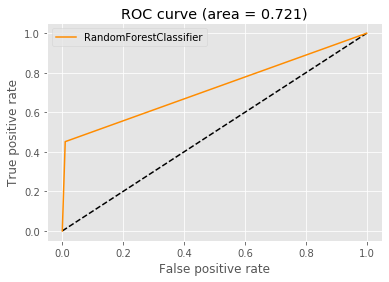

[[ 14  17]
 [  1 103]]

accuracy................. 0.8667
precision................ 0.8583
recall................... 0.9904
auc...................... 0.7210
F1 macro................. 0.7642
F1 micro................. 0.8667
F1 weighted.............. 0.8482
F1 binary................ 0.6087


In [14]:
model = train_random_forest(_x, 'canceled')

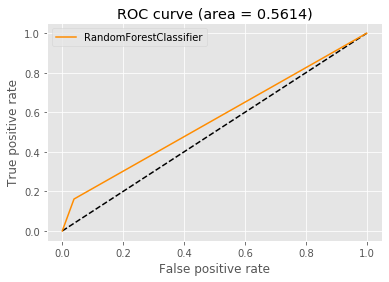

[[  5  26]
 [  4 100]]

accuracy................. 0.7778
precision................ 0.7937
recall................... 0.9615
auc...................... 0.5614
F1 macro................. 0.5598
F1 micro................. 0.7778
F1 weighted.............. 0.7273
F1 binary................ 0.2500


In [102]:
model = train_random_forest(_x, 'canc')

In [ ]:
importances = pd.Series(model.feature_importances_, index = average_columns).to_frame().reset_index()
importances.columns = ['feature', 'importance']
importances.sort_values(by = 'importance', ascending = False)

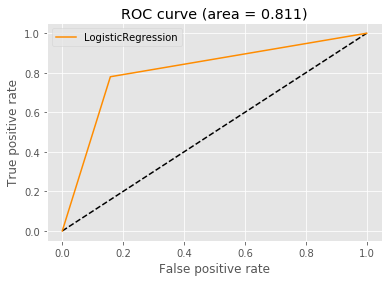

[[1184  334]
 [ 816 4350]]

accuracy................. 0.8279
precision................ 0.9287
recall................... 0.8420
auc...................... 0.8110
F1 macro................. 0.7782
F1 micro................. 0.8279
F1 weighted.............. 0.8355
F1 binary................ 0.6731


In [14]:
model = train_logistic_regression(_x, 'canceled')

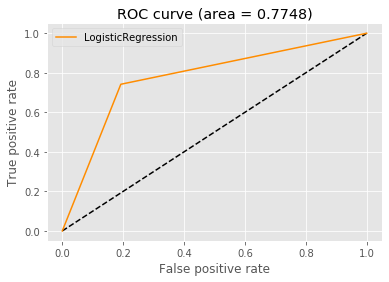

[[23  8]
 [20 84]]

accuracy................. 0.7926
precision................ 0.9130
recall................... 0.8077
auc...................... 0.7748
F1 macro................. 0.7394
F1 micro................. 0.7926
F1 weighted.............. 0.8031
F1 binary................ 0.6216


In [45]:
model = train_logistic_regression(_x, 'canceled')

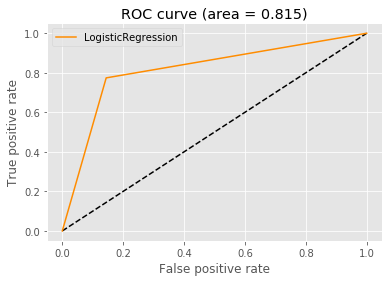

[[24  7]
 [15 89]]

accuracy................. 0.8370
precision................ 0.9271
recall................... 0.8558
auc...................... 0.8150
F1 macro................. 0.7879
F1 micro................. 0.8370
F1 weighted.............. 0.8431
F1 binary................ 0.6857


In [16]:
model = train_logistic_regression(_x, 'canceled')

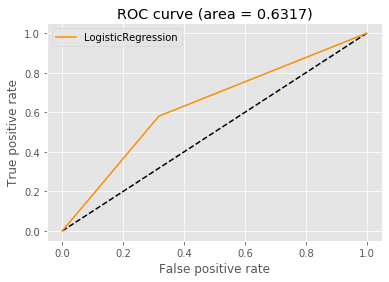

[[18 13]
 [33 71]]

accuracy................. 0.6593
precision................ 0.8452
recall................... 0.6827
auc...................... 0.6317
F1 macro................. 0.5972
F1 micro................. 0.6593
F1 weighted.............. 0.6827
F1 binary................ 0.4390


In [103]:
model = train_logistic_regression(_x, 'canc')